In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import os

In [ ]:
# Set up Kaggle credentials
os.makedirs('/root/.kaggle/', exist_ok=True)
!cp /content/drive/MyDrive/Kaggle/kaggle.json /root/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json  # Secure permissions

In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

valid_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
dataset_path = "/content/drive/MyDrive/Datasets/TomatoLeaf/tomato"

training_set = train_datagen.flow_from_directory(
    dataset_path + "/train",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 10046 images belonging to 10 classes.


In [ ]:
validation_set = valid_datagen.flow_from_directory(
    dataset_path + "/val",
    target_size=(128, 128),
    batch_size=32,
    class_mode='categorical'
)

Found 1047 images belonging to 10 classes.


In [ ]:
num_classes = training_set.num_classes  # Dynamically get number of classes

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import GlobalAveragePooling2D, Dropout, Dense
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

In [ ]:
# Load Pretrained Model
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False  # Freeze initial layers

9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [ ]:
# Define the Model
cnn = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(512, activation='relu'),
    Dropout(0.4),
    Dense(num_classes, activation='softmax')
])

In [ ]:
# Compile the Model
cnn.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
            loss='categorical_crossentropy',
            metrics=['accuracy'])

In [ ]:
# Callbacks
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-6)
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

In [ ]:
training_history = cnn.fit(training_set,
                           validation_data=validation_set,
                           epochs=30,
                           callbacks=[early_stopping, lr_scheduler])

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/30
  9/314 ━━━━━━━━━━━━━━━━━━━━ 37:51 7s/step - accuracy: 0.0911 - loss: 2.8172

KeyboardInterrupt: 

In [ ]:
# Evaluate Model Performance
train_loss, train_acc = cnn.evaluate(training_set)
val_loss, val_acc = cnn.evaluate(validation_set)
print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
print(f"Validation Loss: {val_loss:.4f}, Validation Accuracy: {val_acc:.4f}")

314/314 ━━━━━━━━━━━━━━━━━━━━ 197s 625ms/step - accuracy: 0.9016 - loss: 0.2925
33/33 ━━━━━━━━━━━━━━━━━━━━ 18s 536ms/step - accuracy: 0.8500 - loss: 0.4948
Train Loss: 0.2928, Train Accuracy: 0.9035
Validation Loss: 0.5358, Validation Accuracy: 0.8271


In [ ]:
# Save Training History
import json
with open('/content/drive/MyDrive/training_hist.json', 'w') as f:
    json.dump(training_history.history, f)

print(training_history.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


In [ ]:
# Save the Model
cnn.save('/content/drive/MyDrive/trained_plant_disease_model.keras')

In [ ]:
cnn.save("/content/drive/MyDrive/trained_tomato_disease_model.h5")


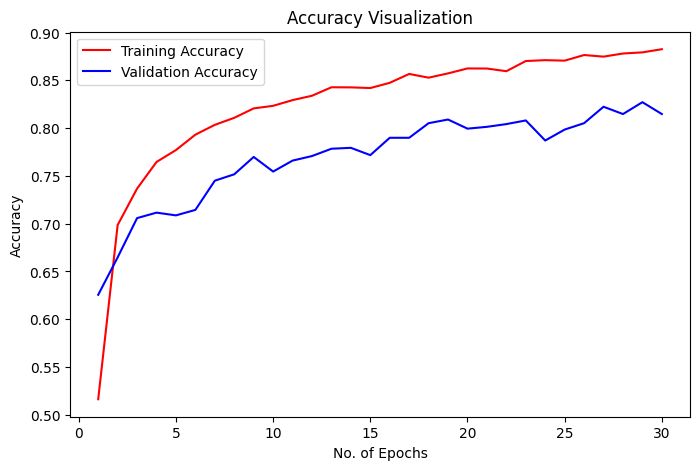

In [ ]:
# Plot Accuracy Curves
import matplotlib.pyplot as plt

# Extract number of epochs from history
num_epochs = len(training_history.history['accuracy'])
epochs = list(range(1, num_epochs + 1))

plt.figure(figsize=(8,5))
plt.plot(epochs, training_history.history['accuracy'], color='red', label='Training Accuracy')
plt.plot(epochs, training_history.history['val_accuracy'], color='blue', label='Validation Accuracy')
plt.xlabel('No. of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy Visualization')
plt.legend()
plt.show()

In [ ]:
# Load Model for Testing
cnn = tf.keras.models.load_model('/content/drive/MyDrive/trained_plant_disease_model.keras')
cnn.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_128 (Functional)    │ (None, 4, 4, 1280)          │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d_1           │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 512)                 │         655,872 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_8 (Dense)                      │ (None, 10)                  │           5,130 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,579,990 (13.66 MB)

 Trainable params: 661,002 (2.52 MB)

 Non-trainable params: 2,257,984 (8.61 MB)

 Optimizer params: 661,004 (2.52 MB)

In [ ]:
import tensorflow as tf

try:
    model = tf.keras.models.load_model("/content/drive/MyDrive/trained_plant_disease_model.keras")
    print("✅ Model loaded successfully!")
except Exception as e:
    print(f"🚨 Error loading model: {e}")


✅ Model loaded successfully!


/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 6 variables whereas the saved optimizer has 10 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


In [ ]:

# Install OpenCV (Only if needed)
try:
    import cv2
except ImportError:
    %pip install opencv-python
    import cv2

In [ ]:
# Test Image Path
image_path = '/content/test/yello curl.webp'

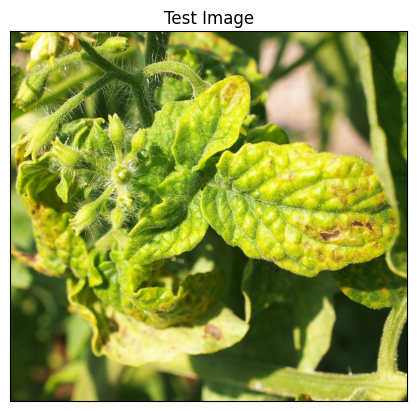

In [ ]:
import cv2
import matplotlib.pyplot as plt  # Correct import
  # Update with actual image path

# Check if the file exists before loading
import os
if not os.path.exists(image_path):
    print("Error: Image file not found!")
else:
    img = cv2.imread(image_path)

    if img is None:
        print("Error: OpenCV couldn't read the image!")
    else:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
        plt.imshow(img)  # Show image
        plt.title('Test Image')
        plt.xticks([])
        plt.yticks([])
        plt.show()


In [ ]:
# Load and Preprocess Test Image
import numpy as np
image = tf.keras.preprocessing.image.load_img(image_path, target_size=(128,128))
input_arr = tf.keras.preprocessing.image.img_to_array(image)
input_arr = np.expand_dims(input_arr, axis=0) / 255.0  # Normalize

In [ ]:
# Softmax with Temperature Scaling
def softmax_with_temperature(logits, temperature=2.0):
    exp_logits = np.exp(logits / temperature)
    return exp_logits / np.sum(exp_logits, axis=1, keepdims=True)

In [ ]:
# Make Predictions
predictions = cnn.predict(input_arr)  # Get raw logits
scaled_predictions = softmax_with_temperature(predictions, temperature=2.0)  # Apply Temperature Scaling


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step


In [ ]:
# Get Class Labels
class_labels = list(training_set.class_indices.keys())  # Ensure class names are retrieved properly


In [ ]:
# Display Prediction
result_index = np.argmax(scaled_predictions)
print("Predicted Class:", class_labels[result_index])

Predicted Class: Tomato___Spider_mites Two-spotted_spider_mite


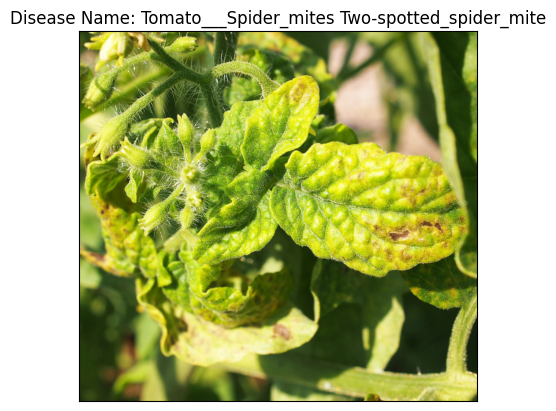

In [ ]:
# Displaying the disease prediction
model_prediction = class_labels[result_index]
plt.imshow(img)
plt.title(f"Disease Name: {model_prediction}")
plt.xticks([])
plt.yticks([])
plt.show()

In [ ]:
!pip install streamlit tensorflow


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.3/44.3 kB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.8/9.8 MB 57.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 87.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.1/79.1 kB 4.9 MB/s eta 0:00:00


In [ ]:
!pip install pyngrok


In [ ]:
import os
os.system("streamlit run /content/drive/MyDrive/main.py &")


0

In [ ]:
!curl ipv4.icanhazip.com

35.229.117.196


In [ ]:
!streamlit run  /content/drive/MyDrive/main.py & npx localtunnel --port 8501




⠙⠹⠸
  You can now view your Streamlit app in your browser.

  Local URL: http://localhost:8501
  Network URL: http://172.28.0.12:8501
  External URL: http://35.229.117.196:8501

⠼⠴your url is: https://nasty-experts-boil.loca.lt
2025-03-26 06:12:04.592447: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1742969524.640407   12131 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1742969524.655926   12131 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-26 06:12:10.528130: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)
/usr/local/lib/python3.11

In [ ]:
# prompt: get ip for the tunnel

!curl ipv4.icanhazip.com


35.229.117.196
